In [1]:
from pyspark.sql import SparkSession
from datetime import datetime
import matplotlib.pyplot as plt
import string
import json
import re

In [2]:
spark_session = SparkSession.builder\
    .master("spark://192.168.2.133:7077")\
    .appName("New Analysis Plan")\
    .config("spark.dynamicAllocation.enabled", False)\
    .config("spark.driver.cores", 1)\
    .config("spark.driver.memory", "1g")\
    .config("spark.executor.cores", 2)\
    .config("spark.executor.memory", "2000m")\
    .config("spark.executor.instances", 4)\
    .getOrCreate()

#     .config("spark.cores.max", 4)\

spark_context = spark_session.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/22 12:56:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/22 12:56:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Read Data and Sample

In [5]:
comments = spark_context.textFile('hdfs://192.168.2.133:9000/user/root/reddit_data/RC_2012-01')

ratio = 1
seed = 81
comments_sampled = comments.sample(False, ratio, seed)

In [6]:
comments.getNumPartitions()

71

### Maps String Into JSON

In [7]:
comments_json = comments_sampled.map(json.loads)

In [8]:
comments_json.take(1)

[{'edited': False,
  'created_utc': '1325376000',
  'controversiality': 0,
  'body': "Isn't this against the first amendment? Doesn't the first amendment give us the right to assemble and protest?",
  'subreddit_id': 't5_2qh3l',
  'parent_id': 't3_nxrpq',
  'author_flair_text': None,
  'id': 'c3ctzsj',
  'score': 5,
  'author_flair_css_class': None,
  'gilded': 0,
  'author': 'goishin',
  'score_hidden': False,
  'retrieved_on': 1428104610,
  'ups': 5,
  'downs': 0,
  'name': 't1_c3ctzsj',
  'distinguished': None,
  'subreddit': 'news',
  'archived': True,
  'link_id': 't3_nxrpq'}]

### Maps JSON Into (`time`, `body`) pairs

In [9]:
def unix_timestamp_converter(input_number):
    """
        Converts 1325376033 into 2012-12-21
    """
    return datetime.utcfromtimestamp(int(input_number)).strftime('%Y-%m-%d')

In [10]:
def timebody_mapper(json_object):
    """
        Converts JSON into a tuple of time and comment body
    """
    date_str = unix_timestamp_converter(json_object["created_utc"])
    body = json_object["body"]
    return (date_str, body)

In [11]:
timebody_pairs = comments_json.map(timebody_mapper)

In [12]:
timebody_pairs.take(1)

[('2012-01-01',
  "Isn't this against the first amendment? Doesn't the first amendment give us the right to assemble and protest?")]

### Punctuation Removal

Works by substituting a punctuation with a space.

In [13]:
def punctuation_remover(input_tuple):
    date = input_tuple[0]
    new_body = re.sub(f"[{string.punctuation}]+", " ", input_tuple[1])
    return (date, new_body.lower())

In [14]:
punctuation_removed = timebody_pairs.map(punctuation_remover)

In [15]:
punctuation_removed.take(1)

[('2012-01-01',
  'isn t this against the first amendment  doesn t the first amendment give us the right to assemble and protest ')]

### Tokenization

In [16]:
tokenized_rdd = punctuation_removed.map(lambda x: (x[0], x[1].split()))

In [17]:
tokenized_rdd.take(1)

[('2012-01-01',
  ['isn',
   't',
   'this',
   'against',
   'the',
   'first',
   'amendment',
   'doesn',
   't',
   'the',
   'first',
   'amendment',
   'give',
   'us',
   'the',
   'right',
   'to',
   'assemble',
   'and',
   'protest'])]

### Sentence Filtering
Remove sentences that don't contain at least one of the given word

In [18]:
important_words = ["btc", "bitcoin", "cryptocurrency", "crypto"]

def sentence_filter(input_tuple):
    return any([word in input_tuple[1] for word in important_words])

In [19]:
filtered_rdd = tokenized_rdd.filter(sentence_filter)

In [20]:
filtered_rdd.count()

2186

In [22]:
filtered_rdd.take(1)

[('2012-01-01',
  ['right',
   'yes',
   'got',
   'it',
   'and',
   'what',
   'does',
   'darknet',
   'tor',
   'gnunet',
   'bitcoin',
   'etc',
   'do',
   'about',
   'that',
   'i',
   'know',
   'that',
   'they',
   'are',
   'uncontrolled',
   'nets',
   'so',
   'why',
   'do',
   'i',
   'the',
   '99',
   'need',
   'them',
   'on',
   'a',
   'daily',
   'basis',
   'what',
   'are',
   'they',
   'going',
   'to',
   'tell',
   'me',
   'or',
   'do',
   'for',
   'me',
   'that',
   'i',
   'can',
   't',
   'find',
   'on',
   'the',
   'internets',
   'i',
   'really',
   'want',
   'to',
   'know'])]

In [23]:
daily_comment_counts = filtered_rdd.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b)

In [24]:
import pandas as pd

bitcoin_data = pd.read_csv('bitstamp_cleaned.csv')
bitcoin_data['DateTime'] = pd.to_datetime(bitcoin_data['DateTime'])
bitcoin_data['Date'] = bitcoin_data['DateTime'].dt.strftime('%Y-%m-%d')
bitcoin_data = bitcoin_data.groupby('Date').agg({'Weighted_Price': 'mean'}).reset_index()

#Calculate the % change in Bitcoin prices
#making plot of two changes 変化

In [29]:
daily_comment_counts_df = daily_comment_counts.toDF(["Date", "Comment_Count"]).toPandas()
merged_data = pd.merge(bitcoin_data, daily_comment_counts_df, on='Date', how='inner')

In [30]:
#merged_data['Price_Change'] = merged_data['Weighted_Price'].pct_change() * 100
merged_data['Price_Change'] = abs(merged_data['Weighted_Price'].pct_change() * 100)

In [39]:
import pandas as pd
merged_data.to_csv('modified_data.csv', index=False)


In [31]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


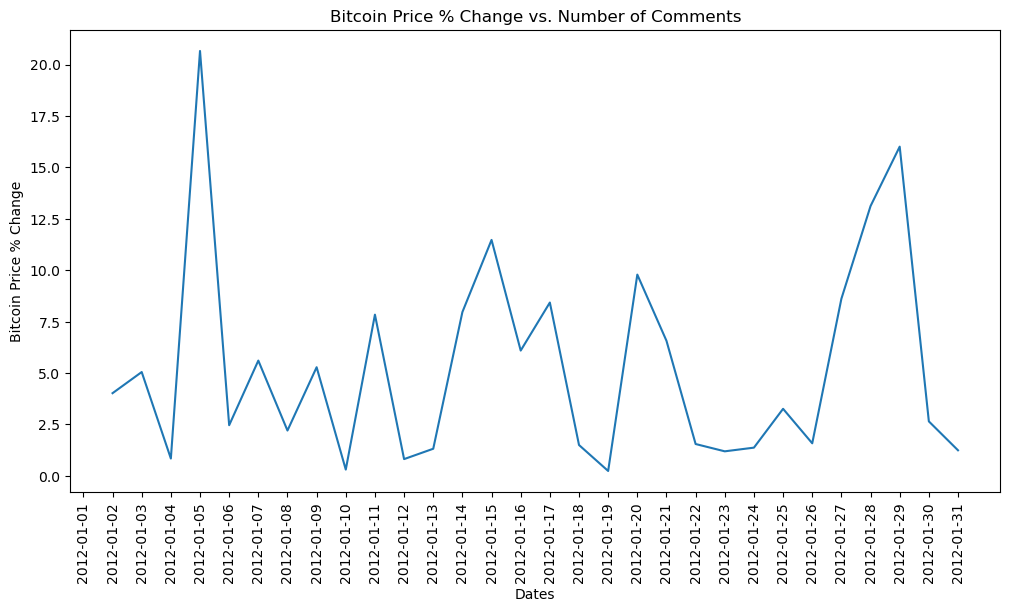

In [32]:
merged_data = merged_data.sort_values(by='Date')

plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['Price_Change'])

plt.xlabel("Dates")
plt.ylabel("Bitcoin Price % Change")
plt.title("Bitcoin Price % Change vs. Number of Comments")
plt.xticks(rotation=90)
plt.show()

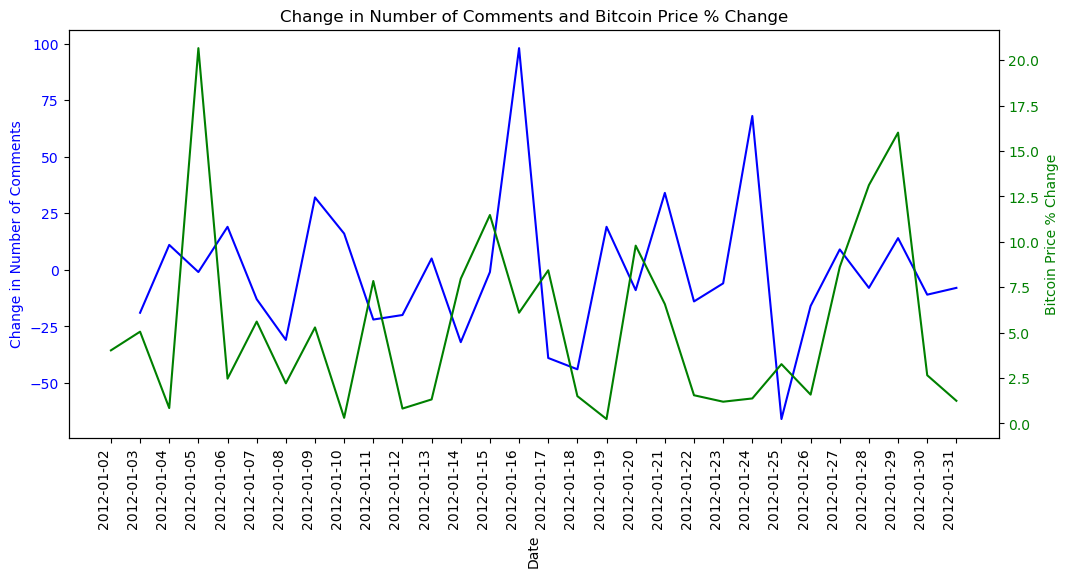

In [43]:
filtered_merged_data = merged_data[merged_data['Price_Change'].notnull()]
filtered_merged_data = filtered_merged_data[filtered_merged_data['Price_Change'] != float('inf')]
filtered_merged_data = filtered_merged_data[filtered_merged_data['Price_Change'] != float('-inf')]

filtered_merged_data['Comment_Change'] = filtered_merged_data['Comment_Count'].diff()

filtered_merged_data.set_index('Date', inplace=True)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(filtered_merged_data.index, filtered_merged_data['Comment_Change'], label='Change in Number of Comments', color='blue')
ax1.set_xlabel('Date',rotation=90)
ax1.set_ylabel('Change in Number of Comments', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(filtered_merged_data.index, filtered_merged_data['Price_Change'], label='Bitcoin Price % Change', color='green')
ax2.set_ylabel('Bitcoin Price % Change', color='green',rotation=90)
ax2.tick_params(axis='y', labelcolor='green')
fig.autofmt_xdate(rotation=90)
plt.title("Change in Number of Comments and Bitcoin Price % Change")

plt.show()


correlation

In [38]:
lag_periods = 5

lagged_data = filtered_merged_data.copy()
lagged_data['Lagged_Comment_Change'] = lagged_data['Comment_Change'].shift(lag_periods)
correlation = lagged_data['Lagged_Comment_Change'].corr(lagged_data['Price_Change'])

print("Correlation between lagged comment changes and price changes:", correlation)

correlation = lagged_data['Comment_Change'].corr(lagged_data['Price_Change'])

print("Correlation between comment changes and price changes:", correlation)

Correlation between lagged comment changes and price changes: 0.45182992473312833
Correlation between comment changes and price changes: 0.00737965283538121


In [36]:
import pandas as pd
correlation_table = pd.DataFrame(columns=['Lag_Period', 'Lagged_Comment_Change_Correlation', 'Comment_Change_Correlation'])

for lag_periods in range(1, 10):
    lagged_data = filtered_merged_data.copy()
    lagged_data['Lagged_Comment_Change'] = lagged_data['Comment_Change'].shift(lag_periods)
    
    lagged_correlation = lagged_data['Lagged_Comment_Change'].corr(lagged_data['Price_Change'])
    original_correlation = lagged_data['Comment_Change'].corr(lagged_data['Price_Change'])
    
    correlation_table = correlation_table.append({
        'Lag_Period': lag_periods,
        'Lagged_Comment_Change_Correlation': lagged_correlation,
        'Comment_Change_Correlation': original_correlation
    }, ignore_index=True)

print(correlation_table)

   Lag_Period  Lagged_Comment_Change_Correlation  Comment_Change_Correlation
0         1.0                           0.199036                     0.00738
1         2.0                          -0.239476                     0.00738
2         3.0                          -0.466965                     0.00738
3         4.0                           0.047951                     0.00738
4         5.0                           0.451830                     0.00738
5         6.0                          -0.038874                     0.00738
6         7.0                          -0.096463                     0.00738
7         8.0                           0.108737                     0.00738
8         9.0                          -0.117397                     0.00738


/tmp/ipykernel_101221/2711994907.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlation_table = correlation_table.append({
/tmp/ipykernel_101221/2711994907.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlation_table = correlation_table.append({
/tmp/ipykernel_101221/2711994907.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlation_table = correlation_table.append({
/tmp/ipykernel_101221/2711994907.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlation_table = correlation_table.append({
/tmp/ipykernel_101221/2711994907.py:11: FutureWarning: The frame.append method is deprecated and will be removed

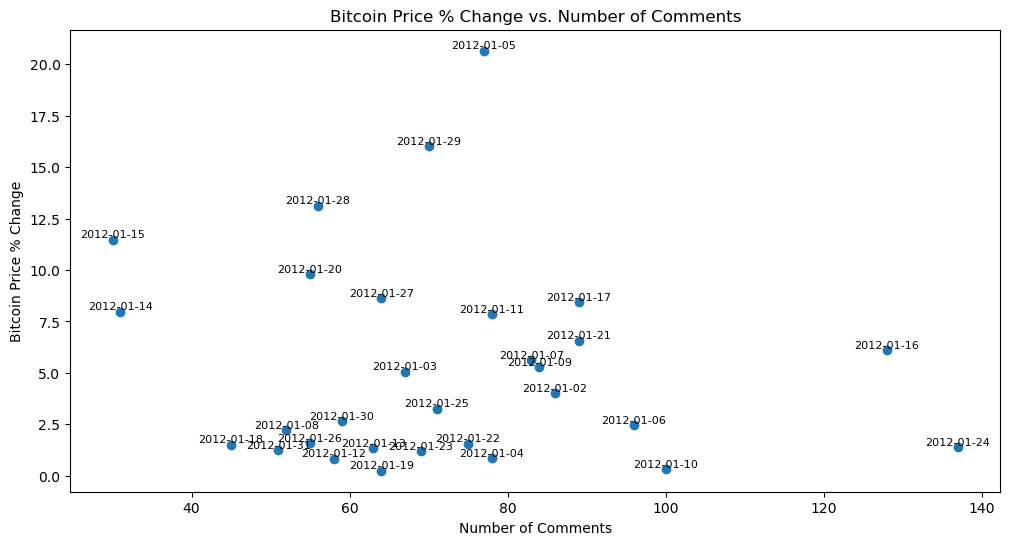

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

filtered_merged_data = merged_data[merged_data['Price_Change'].notnull()]
filtered_merged_data = filtered_merged_data[filtered_merged_data['Price_Change'] != float('inf')]
filtered_merged_data = filtered_merged_data[filtered_merged_data['Price_Change'] != float('-inf')]

plt.figure(figsize=(12, 6))
plt.scatter(filtered_merged_data['Comment_Count'], filtered_merged_data['Price_Change'])

for i, date in enumerate(filtered_merged_data['Date']):
    plt.text(filtered_merged_data['Comment_Count'].iloc[i], filtered_merged_data['Price_Change'].iloc[i], date, fontsize=8, ha='center', va='bottom')

plt.xlabel("Number of Comments")
plt.ylabel("Bitcoin Price % Change")
plt.title("Bitcoin Price % Change vs. Number of Comments")
plt.show()

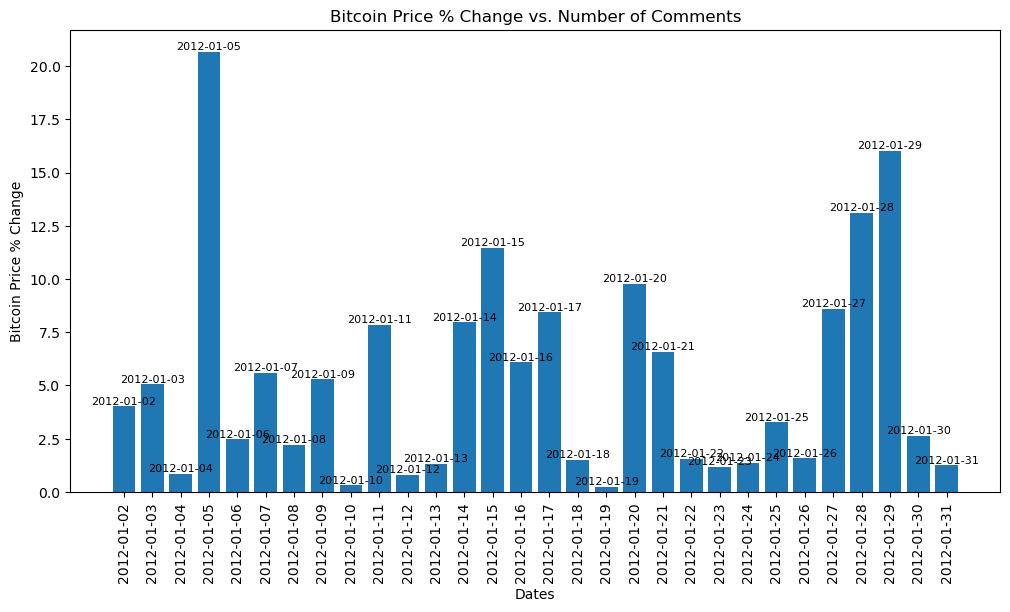

In [52]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(filtered_merged_data['Comment_Count'])), filtered_merged_data['Price_Change'])


for i, date in enumerate(filtered_merged_data['Date']):
    plt.text(i, filtered_merged_data['Price_Change'].iloc[i], date, fontsize=8, ha='center', va='bottom')

plt.xlabel("Dates")
plt.ylabel("Bitcoin Price % Change")
plt.title("Bitcoin Price % Change vs. Number of Comments")
plt.xticks(range(len(filtered_merged_data['Date'])), filtered_merged_data['Date'], rotation=90)
plt.show()

In [54]:
daily_comment_counts = filtered_rdd.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b)

daily_comment_counts_df = daily_comment_counts.toDF(["Date", "Comment_Count"]).toPandas()
daily_comment_counts_df['Date'] = pd.to_datetime(daily_comment_counts_df['Date'])
daily_comment_counts_df['Week'] = daily_comment_counts_df['Date'].dt.to_period('W').apply(lambda r: r.start_time)

weekly_comment_counts = daily_comment_counts_df.groupby('Week')['Comment_Count'].sum().reset_index()

print("Weekly Comment Counts in January 2012:")
print(weekly_comment_counts.to_string(index=False))

print("\nDaily Comment Counts in January 2012:")
print(daily_comment_counts_df[['Date', 'Comment_Count']].to_string(index=False))


Weekly Comment Counts in January 2012:
      Week  Comment_Count
2011-12-26             11
2012-01-02            292
2012-01-09            237
2012-01-16            265
2012-01-23            264
2012-01-30             55

Daily Comment Counts in January 2012:
      Date  Comment_Count
2012-01-02             40
2012-01-15             15
2012-01-19             28
2012-01-03             38
2012-01-07             48
2012-01-12             29
2012-01-14             14
2012-01-29             35
2012-01-22             37
2012-01-16             71
2012-01-31             24
2012-01-08             29
2012-01-05             39
2012-01-06             53
2012-01-30             31
2012-01-04             45
2012-01-01             11
2012-01-10             50
2012-01-24             66
2012-01-17             40
2012-01-28             31
2012-01-09             40
2012-01-20             30
2012-01-25             45
2012-01-23             29
2012-01-27             34
2012-01-11             51
2012-01-26  

In [37]:
spark_session.stop()

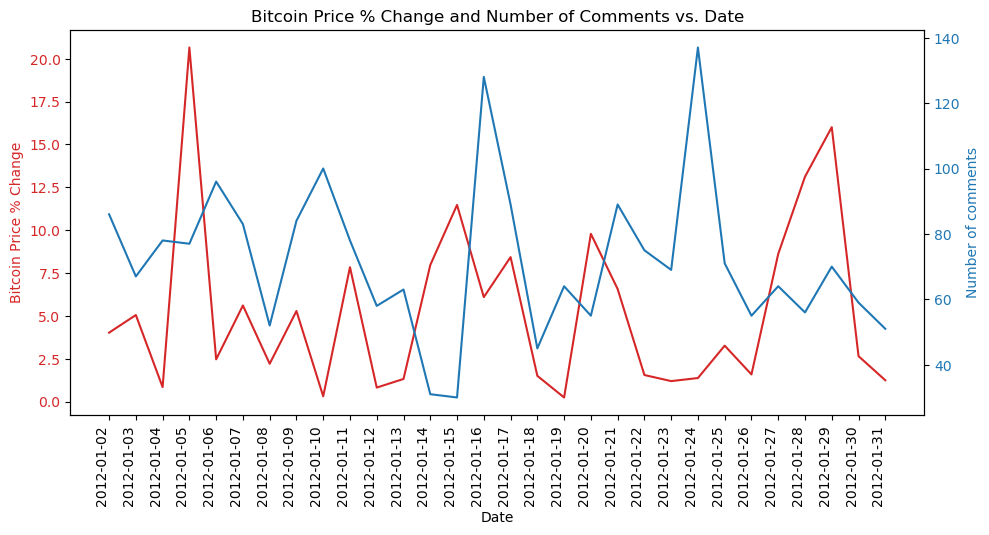

In [42]:
# Create some mock data

fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel("Bitcoin Price % Change", color=color)
ax1.plot(merged_data['Date'][1:], merged_data['Price_Change'][1:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of comments', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_data['Date'][1:], filtered_merged_data['Comment_Count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.autofmt_xdate(rotation=90)
plt.title("Bitcoin Price % Change and Number of Comments vs. Date")
plt.show()

In [28]:
filtered_merged_data['Comment_Count'][-5:]

26    64
27    56
28    70
29    59
30    51
Name: Comment_Count, dtype: int64

In [29]:
merged_data['Price_Change']

0           NaN
1      4.022191
2      5.050000
3      0.844183
4     20.659273
5      2.464493
6      5.606476
7      2.205882
8      5.283890
9      0.307323
10     7.840146
11     0.817124
12     1.320545
13     7.965798
14    11.473487
15     6.093906
16     8.428887
17     1.501904
18     0.239944
19     9.786599
20     6.569129
21     1.550266
22     1.195066
23     1.374258
24     3.262104
25     1.584617
26     8.613443
27    13.119312
28    16.008147
29     2.650983
30     1.245184
Name: Price_Change, dtype: float64

In [31]:
merged_data['Date']

0     2012-01-01
1     2012-01-02
2     2012-01-03
3     2012-01-04
4     2012-01-05
5     2012-01-06
6     2012-01-07
7     2012-01-08
8     2012-01-09
9     2012-01-10
10    2012-01-11
11    2012-01-12
12    2012-01-13
13    2012-01-14
14    2012-01-15
15    2012-01-16
16    2012-01-17
17    2012-01-18
18    2012-01-19
19    2012-01-20
20    2012-01-21
21    2012-01-22
22    2012-01-23
23    2012-01-24
24    2012-01-25
25    2012-01-26
26    2012-01-27
27    2012-01-28
28    2012-01-29
29    2012-01-30
30    2012-01-31
Name: Date, dtype: object